In [1]:
#Import the necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

In [2]:
#Create a sample DF - Datetime, Lane, Direction, Class, Rate, Volume, and Revenue
np.random.seed(42)

start_date = datetime(2023, 1, 1)
end_date = datetime(2025, 9, 10)
date_range = pd.date_range(start=start_date, end=end_date, freq='h')

lanes = [f"Lane_{i}" for i in range(1, 23)]
lane_directions = {f"Lane_{i}": "Eastbound" if i <= 11 else "Westbound" for i in range(1, 23)}

vehicle_classes = [2, 3, 4, 5, 6, 7]
weather_conditions = ['Clear', 'Cloudy', 'Rainy', 'Foggy', 'Snowing']

def get_toll_rate(vehicle_class, hour):
    peak = 4 <= hour < 20
    if vehicle_class == 2:
        return 7.80
    elif vehicle_class == 3:
        return 27.20 if peak else 19.50
    elif vehicle_class == 4:
        return 36.30 if peak else 25.90
    elif vehicle_class == 5:
        return 45.40 if peak else 32.40
    elif vehicle_class == 6:
        return 54.40 if peak else 38.90
    else:
        return 63.50 if peak else 45.40

data = []
for dt in date_range:
    for lane in lanes:
        direction = lane_directions[lane]
        for vehicle_class in vehicle_classes:
            volume = np.random.poisson(lam=5 if 4 <= dt.hour < 20 else 2)
            toll_rate = get_toll_rate(vehicle_class, dt.hour)
            revenue = volume * toll_rate
            weather = random.choices(weather_conditions, weights=[50, 20, 15, 10, 5])[0]
            data.append({
                'Datetime': dt,
                'Lane': lane,
                'Direction': direction,
                'VehicleClass': vehicle_class,
                'TollRate': toll_rate,
                'Volume': volume,
                'Weather': weather,
                'Revenue': revenue,
                'DayOfWeek': dt.strftime('%A'),
                'Hour': dt.hour
            })

df = pd.DataFrame(data)

In [3]:
df.head()

,Datetime,Lane,Direction,VehicleClass,TollRate,Volume,Weather,Revenue,DayOfWeek,Hour
0,2023-01-01,Lane_1,Eastbound,2,7.8,4,Clear,31.2,Sunday,0
1,2023-01-01,Lane_1,Eastbound,3,19.5,1,Rainy,19.5,Sunday,0
2,2023-01-01,Lane_1,Eastbound,4,25.9,3,Cloudy,77.7,Sunday,0
3,2023-01-01,Lane_1,Eastbound,5,32.4,3,Foggy,97.2,Sunday,0
4,2023-01-01,Lane_1,Eastbound,6,38.9,1,Clear,38.9,Sunday,0


In [4]:
#This is the total number of rows in the sample df. This should be a good enough number to run exploratory analysis from.
print(f"There are {df.shape[0]} rows of data in the dataframe.")

There are 3114276 rows of data in the dataframe.


In [5]:
#Aggregate the df by Day - Look at Volume & Revenue Columns
daily_df = (
    df.groupby(df["Datetime"].dt.date)[["Volume", "Revenue"]]
    .sum()
    .reset_index()
    .rename(columns={"Datetime": "Date"})
)

#print("Daily shape:", daily_df.shape)

In [6]:
daily_df.head()

,Date,Volume,Revenue
0,2023-01-01,12554,468448.8
1,2023-01-02,12882,484462.9
2,2023-01-03,12630,474772.1
3,2023-01-04,12704,471386.5
4,2023-01-05,12816,480713.9


In [7]:
#Daily Traffic Volume (Weekday vs. Weekend)

#Add a DayOfWeek/IsWeekend columns
daily_df["Date"] = pd.to_datetime(daily_df["Date"])
daily_df["DayOfWeek"] = daily_df["Date"].dt.day_name()
daily_df["IsWeekend"] = daily_df["DayOfWeek"].isin(["Saturday", "Sunday"])

#daily_df.head()

In [8]:
#Model that will be used for Analysis: XGBOOST
#Note: This was previosuly decided in the initial workbook

In [9]:
import warnings

#Ignore all DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
#Import the necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [11]:
df_ml = daily_df.copy()
#df_ml.head()

#Lag Features
df_ml["lag1"] = df_ml["Volume"].shift(1)
df_ml["lag2"] = df_ml["Volume"].shift(2)
df_ml["lag7"] = df_ml["Volume"].shift(7)

#Rolling Features
df_ml["roll3"] = df_ml["Volume"].shift(1).rolling(3).mean()
df_ml["roll7"] = df_ml["Volume"].shift(1).rolling(7).mean()

#Drop the null values
df_ml = df_ml.dropna()
#df_ml.head()

#Features/Target
X = df_ml[["lag1", "lag2", "lag7", "roll3", "roll7", "IsWeekend"]]
y = df_ml["Volume"]

#Train-Test Split
X_train, X_test, y_train, y_test = X.iloc[:-7], X.iloc[-7:], y.iloc[:-7], y.iloc[-7:]

In [12]:
#XGBoost Model
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [13]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Future 21 Days
HORIZON = 21

#last_date = last_date = daily_df.index.max()
last_date = daily_df["Date"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=HORIZON, freq="D")

vol_series = daily_df["Volume"].copy()

future_rows = []

for dt in future_dates:
    lag1 = vol_series.iloc[-1]
    lag2 = vol_series.iloc[-2]
    lag7 = vol_series.iloc[-7]
    roll3 = vol_series.iloc[-3:].mean()
    roll7 = vol_series.iloc[-7:].mean()
    is_weekend = pd.Timestamp(dt).day_name() in ["Saturday", "Sunday"]

    X_next = pd.DataFrame([{
        "lag1": lag1, "lag2": lag2, "lag7": lag7,
        "roll3": roll3, "roll7": roll7,
        "IsWeekend": is_weekend
    }], index=[dt])

    y_hat = float(model.predict(X_next))

    vol_series.loc[dt] = y_hat

    future_rows.append({
        "Date": dt,
        "Forecast_Volume": y_hat
    })

xgb_future_df = pd.DataFrame(future_rows).set_index("Date").round(3)

#xgb_future_df
#xgb_future_df.head()

#Past 21 Days
lookback = 21

if "Date" in daily_df.columns:
    daily_idx = daily_df.copy()
    daily_idx["Date"] = pd.to_datetime(daily_idx["Date"])
    daily_idx = daily_idx.set_index("Date")
else:
    daily_idx = daily_df.copy()
    daily_idx.index = pd.to_datetime(daily_idx.index)

actual_tail = (
    daily_idx[["Volume"]]
    .iloc[-lookback:]
    .rename(columns={"Volume": "Actual_Volume"})
)

xgb_future_df = xgb_future_df.copy()
xgb_future_df.index = pd.to_datetime(xgb_future_df.index)

plot_df = actual_tail.join(xgb_future_df, how="outer")
#plot_df

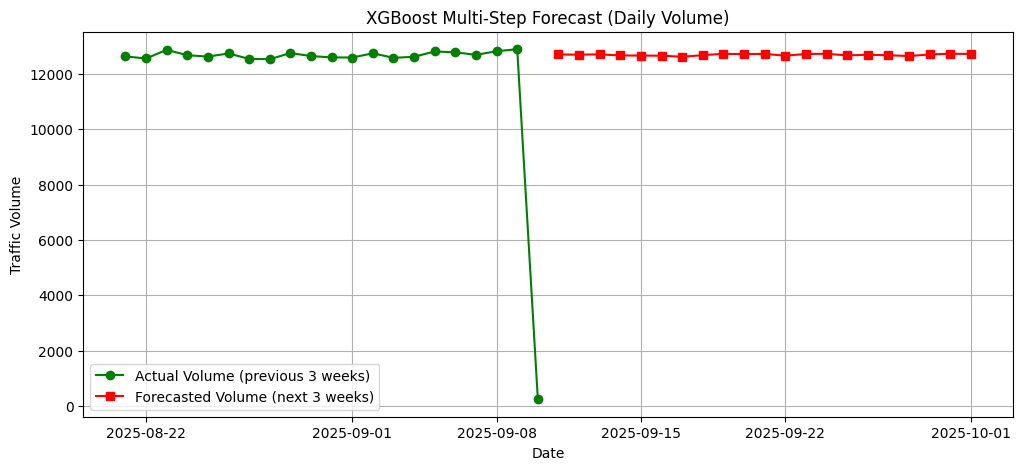

In [14]:
#Create a Plot of the Data
plt.figure(figsize=(12, 5))
plt.plot(
    plot_df.index,
    plot_df["Actual_Volume"],
    label="Actual Volume (previous 3 weeks)",
    color="green",
    marker="o"
    )
plt.plot(
    plot_df.index,
    plot_df["Forecast_Volume"],
    label="Forecasted Volume (next 3 weeks)",
    color="red",
    marker="s"
    )
plt.title("XGBoost Multi-Step Forecast (Daily Volume)")
plt.xlabel("Date")
plt.ylabel("Traffic Volume")
plt.grid()
plt.legend()

plt.show()

In [15]:
#Q: Evaluate the changes in Toll Rate and how it would affect Traffic Volume & Revenue
#Note: In reality, I need "ACTUAL TRAFFIC DATA" for a "MORE ACCURATE REPRESENTATION"

In [16]:
#Aggregate the df by Day - Look at Volume & Revenue Columns
daily_df = (
    df.groupby(df["Datetime"].dt.date)[["Volume", "Revenue", "TollRate"]]
    #.sum()
    #.reset_index()
    .agg({"Volume": "sum", "Revenue": "sum", "TollRate": "mean"})
    .reset_index()
    .rename(columns={"Datetime": "Date"})
)

#print("Daily shape:", daily_df.shape)

In [17]:
daily_df.head()

,Date,Volume,Revenue,TollRate
0,2023-01-01,12554,468448.8,35.505556
1,2023-01-02,12882,484462.9,35.505556
2,2023-01-03,12630,474772.1,35.505556
3,2023-01-04,12704,471386.5,35.505556
4,2023-01-05,12816,480713.9,35.505556


In [18]:
#Daily Traffic Volume (Weekday vs. Weekend)

#Add a DayOfWeek/IsWeekend columns
daily_df["Date"] = pd.to_datetime(daily_df["Date"])
daily_df["DayOfWeek"] = daily_df["Date"].dt.day_name()
daily_df["IsWeekend"] = daily_df["DayOfWeek"].isin(["Saturday", "Sunday"])

daily_df.head()

,Date,Volume,Revenue,TollRate,DayOfWeek,IsWeekend
0,2023-01-01,12554,468448.8,35.505556,Sunday,True
1,2023-01-02,12882,484462.9,35.505556,Monday,False
2,2023-01-03,12630,474772.1,35.505556,Tuesday,False
3,2023-01-04,12704,471386.5,35.505556,Wednesday,False
4,2023-01-05,12816,480713.9,35.505556,Thursday,False


In [19]:
#Retrain XGBoost Model with Daily TollRate Column Added

In [20]:
#Distinct VehicleClass/TollRate Combinations
#Link: https://www.chicagoskyway.org/toll-information/
vc_tr_combinations = df[['VehicleClass', 'TollRate']].drop_duplicates()
vc_tr_combinations.sort_values(by='VehicleClass', inplace=True)
vc_tr_combinations

,VehicleClass,TollRate
0,2,7.8
1,3,19.5
529,3,27.2
2,4,25.9
530,4,36.3
3,5,32.4
531,5,45.4
4,6,38.9
532,6,54.4
5,7,45.4


In [21]:
#Note: Add Evaluation Metrics to see if the XGBoost model under/or outperforms the baseline

In [22]:
#Import the necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#MAE, RMSE/SMAPE Metrics
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

epsilon = 1e-10
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred) + epsilon))

print("XGBoost Model:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error):{rmse:.2f}")
print(f"sMAPE (Symmetric Mean Absolute Percentage Error): {smape:.2f}%")

XGBoost Model:
MAE (Mean Absolute Error): 1875.24
RMSE (Root Mean Squared Error):4714.89
sMAPE (Symmetric Mean Absolute Percentage Error): 28.25%


In [23]:
# Seasonal Naive Baseline (lag-7)
y_naive = X_test['lag7'].values

mae_naive = mean_absolute_error(y_test, y_naive)
mse_naive = mean_squared_error(y_test, y_naive)
rmse_naive = np.sqrt(mse_naive)

epsilon = 1e-10
smape_naive = 100 * np.mean(2 * np.abs(y_naive - y_test) / (np.abs(y_test) + np.abs(y_naive) + epsilon))

print("Seasonal Naive Baseline (Lag-7) Model:")
print(f"MAE (Mean Absolute Error): {mae_naive:.2f}")
print(f"RMSE (Root Mean Squared Error):{rmse_naive:.2f}")
print(f"sMAPE (Symmetric Mean Absolute Percentage Error): {smape_naive:.2f}%")

Seasonal Naive Baseline (Lag-7) Model:
MAE (Mean Absolute Error): 1870.57
RMSE (Root Mean Squared Error):4667.31
sMAPE (Symmetric Mean Absolute Percentage Error): 28.35%


In [24]:
#Note: Need to improve the Model
#Idea 1: Swap TollRate w/ AvgTollPaid

In [25]:
daily_df = (
    df.groupby(df["Datetime"].dt.date)[["Volume", "Revenue", "TollRate"]]
      .agg({"Volume": "sum", "Revenue": "sum"})
      .reset_index()
      .rename(columns={"Datetime": "Date"})
)

daily_df["Date"] = pd.to_datetime(daily_df["Date"])
#AvgTollPaid
daily_df["AvgTollPaid"] = daily_df["Revenue"] / daily_df["Volume"]

daily_df["DayOfWeek"] = daily_df["Date"].dt.day_name()
daily_df["IsWeekend"] = daily_df["DayOfWeek"].isin(["Saturday", "Sunday"])

daily_df.head()


,Date,Volume,Revenue,AvgTollPaid,DayOfWeek,IsWeekend
0,2023-01-01,12554,468448.8,37.314704,Sunday,True
1,2023-01-02,12882,484462.9,37.607739,Monday,False
2,2023-01-03,12630,474772.1,37.590823,Tuesday,False
3,2023-01-04,12704,471386.5,37.105361,Wednesday,False
4,2023-01-05,12816,480713.9,37.508887,Thursday,False


In [26]:
df_ml = daily_df.copy()
#df_ml.head()

#Lag Features
df_ml["lag1"] = df_ml["Volume"].shift(1)
df_ml["lag2"] = df_ml["Volume"].shift(2)
df_ml["lag7"] = df_ml["Volume"].shift(7)

#Rolling Features
df_ml["roll3"] = df_ml["Volume"].shift(1).rolling(3).mean()
df_ml["roll7"] = df_ml["Volume"].shift(1).rolling(7).mean()

#Drop the null values
df_ml = df_ml.dropna()
#df_ml.head()

#Features/Target
X = df_ml[["lag1", "lag2", "lag7", "roll3", "roll7", "IsWeekend", "AvgTollPaid"]]
y = df_ml["Volume"]

#Train-Test Split
X_train, X_test, y_train, y_test = X.iloc[:-7], X.iloc[-7:], y.iloc[:-7], y.iloc[-7:]

In [27]:
#XGBoost Model
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [28]:
#Import the necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#MAE, RMSE/SMAPE Metrics
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

epsilon = 1e-10
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred) + epsilon))

print("XGBoost Model:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error):{rmse:.2f}")
print(f"sMAPE (Symmetric Mean Absolute Percentage Error): {smape:.2f}%")

XGBoost Model:
MAE (Mean Absolute Error): 1894.01
RMSE (Root Mean Squared Error):4743.87
sMAPE (Symmetric Mean Absolute Percentage Error): 28.32%


In [29]:
# Seasonal Naive Baseline (lag-7)
y_naive = X_test['lag7'].values

mae_naive = mean_absolute_error(y_test, y_naive)
mse_naive = mean_squared_error(y_test, y_naive)
rmse_naive = np.sqrt(mse_naive)

epsilon = 1e-10
smape_naive = 100 * np.mean(2 * np.abs(y_naive - y_test) / (np.abs(y_test) + np.abs(y_naive) + epsilon))

print("Seasonal Naive Baseline (Lag-7) Model:")
print(f"MAE (Mean Absolute Error): {mae_naive:.2f}")
print(f"RMSE (Root Mean Squared Error):{rmse_naive:.2f}")
print(f"sMAPE (Symmetric Mean Absolute Percentage Error): {smape_naive:.2f}%")

Seasonal Naive Baseline (Lag-7) Model:
MAE (Mean Absolute Error): 1870.57
RMSE (Root Mean Squared Error):4667.31
sMAPE (Symmetric Mean Absolute Percentage Error): 28.35%


In [30]:
#Idea 2: Longer Trend Features/Evaluating Across Multiple Weeks

In [31]:
df_ml = daily_df.copy()

df_ml["lag1"] = df_ml["Volume"].shift(1)
df_ml["lag2"] = df_ml["Volume"].shift(2)
df_ml["lag7"] = df_ml["Volume"].shift(7)

df_ml["roll3"]  = df_ml["Volume"].shift(1).rolling(3).mean()
df_ml["roll7"]  = df_ml["Volume"].shift(1).rolling(7).mean()
df_ml["roll14"] = df_ml["Volume"].shift(1).rolling(14).mean()
df_ml["roll30"] = df_ml["Volume"].shift(1).rolling(30).mean()

#Drop the null values
df_ml = df_ml.dropna()
#df_ml.head()

#Features/Target
X = df_ml[["lag1","lag2","lag7","roll3","roll7","roll14","roll30","IsWeekend","AvgTollPaid"]]
y = df_ml["Volume"]

#Train-Test Split
X_train, X_test, y_train, y_test = X.iloc[:-7], X.iloc[-7:], y.iloc[:-7], y.iloc[-7:]

In [32]:
#XGBoost Model
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [33]:
#Import the necessary libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

#MAE, RMSE/SMAPE Metrics
mae = mean_absolute_error(y_test, y_pred)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

epsilon = 1e-10
smape = 100 * np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred) + epsilon))

print("XGBoost Model:")
print(f"MAE (Mean Absolute Error): {mae:.2f}")
print(f"RMSE (Root Mean Squared Error):{rmse:.2f}")
print(f"sMAPE (Symmetric Mean Absolute Percentage Error): {smape:.2f}%")

XGBoost Model:
MAE (Mean Absolute Error): 1883.72
RMSE (Root Mean Squared Error):4728.28
sMAPE (Symmetric Mean Absolute Percentage Error): 28.28%


In [34]:
# Seasonal Naive Baseline (lag-7)
y_naive = X_test['lag7'].values

mae_naive = mean_absolute_error(y_test, y_naive)
mse_naive = mean_squared_error(y_test, y_naive)
rmse_naive = np.sqrt(mse_naive)

epsilon = 1e-10
smape_naive = 100 * np.mean(2 * np.abs(y_naive - y_test) / (np.abs(y_test) + np.abs(y_naive) + epsilon))

print("Seasonal Naive Baseline (Lag-7) Model:")
print(f"MAE (Mean Absolute Error): {mae_naive:.2f}")
print(f"RMSE (Root Mean Squared Error):{rmse_naive:.2f}")
print(f"sMAPE (Symmetric Mean Absolute Percentage Error): {smape_naive:.2f}%")

Seasonal Naive Baseline (Lag-7) Model:
MAE (Mean Absolute Error): 1870.57
RMSE (Root Mean Squared Error):4667.31
sMAPE (Symmetric Mean Absolute Percentage Error): 28.35%


In [35]:
#TDL: I need to make the model more accurate. In the meantime, let's see what Toll Rate Change does to the calculations (Volume/Revenue?

In [36]:
def forecast_toll_scenario(model, df, vehicle_class=2, change_pct=0.10, horizon=7):
    df_adj = df.copy()
    mask = df_adj["VehicleClass"] == vehicle_class
    df_adj.loc[mask, "TollRate"] *= (1 + change_pct)
    df_adj["Revenue"] = df_adj["Volume"] * df_adj["TollRate"]

    daily_adj = (
        df_adj.groupby(df_adj["Datetime"].dt.date)[["Volume", "Revenue"]].sum().reset_index()
    )
    daily_adj = daily_adj.rename(columns={"Datetime": "Date"})
    daily_adj["Date"] = pd.to_datetime(daily_adj["Date"])
    daily_adj["AvgTollPaid"] = daily_adj["Revenue"] / daily_adj["Volume"]
    daily_adj["DayOfWeek"] = daily_adj["Date"].dt.day_name()
    daily_adj["IsWeekend"] = daily_adj["DayOfWeek"].isin(["Saturday", "Sunday"])

    df_ml = daily_adj.copy()
    df_ml["lag1"] = df_ml["Volume"].shift(1)
    df_ml["lag2"] = df_ml["Volume"].shift(2)
    df_ml["lag7"] = df_ml["Volume"].shift(7)
    df_ml["roll3"] = df_ml["Volume"].shift(1).rolling(3).mean()
    df_ml["roll7"] = df_ml["Volume"].shift(1).rolling(7).mean()
    df_ml["roll14"] = df_ml["Volume"].shift(1).rolling(14).mean()
    df_ml["roll30"] = df_ml["Volume"].shift(1).rolling(30).mean()
    df_ml = df_ml.dropna().reset_index(drop=True)

    feature_cols = ["lag1","lag2","lag7","roll3","roll7","roll14","roll30","IsWeekend","AvgTollPaid"]
    X_adj = df_ml[feature_cols]
    y_pred = model.predict(X_adj.tail(horizon))

    orig_last = daily_df.tail(horizon).reset_index(drop=True)
    new_last  = daily_adj.tail(horizon).reset_index(drop=True)

    results = pd.DataFrame({
        "Date": orig_last["Date"],
        "Prev_Volume": orig_last["Volume"],
        "Prev_Revenue": orig_last["Revenue"],
        "New_Volume": y_pred,
        "New_Revenue": y_pred * new_last["AvgTollPaid"],
        "Diff_Volume": y_pred - orig_last["Volume"],
        "Diff_Revenue": (y_pred * new_last["AvgTollPaid"]) - orig_last["Revenue"]
    })

    return results

In [37]:
scenario_results = forecast_toll_scenario(model, df, vehicle_class=2, change_pct=0.2, horizon=60)
#scenario_results

In [38]:
#Drop the last row of data
scenario_results = scenario_results.iloc[:-1]

In [39]:
#Find the Percent Change in Volume and Revenue

In [40]:
total_prev_vol = scenario_results["Prev_Volume"].sum()
total_new_vol  = scenario_results["New_Volume"].sum()
total_prev_rev = scenario_results["Prev_Revenue"].sum()
total_new_rev  = scenario_results["New_Revenue"].sum()

total_vol_change = total_new_vol - total_prev_vol
total_rev_change = total_new_rev - total_prev_rev

pct_vol_change = (total_vol_change / total_prev_vol) * 100
pct_rev_change = (total_rev_change / total_prev_rev) * 100

summary = pd.DataFrame({
    "Total Prev. Vol.": [round(total_prev_vol, 2)],
    "Total New Vol.": [round(total_new_vol, 2)],
    "Total Change in Vol.": [round(total_vol_change, 2)],
    "% Vol. Change": [f"{round(pct_vol_change, 2)}%"],
    "Total Prev. Rev.": [round(total_prev_rev, 2)],
    "Total New Rev.": [round(total_new_rev, 2)],
    "Total Change in Rev.": [round(total_rev_change, 2)],
    "% Rev. Change": [f"{round(pct_rev_change, 2)}%"]
})

summary

,Total Prev. Vol.,Total New Vol.,Total Change in Vol.,% Vol. Change,Total Prev. Rev.,Total New Rev.,Total Change in Rev.,% Rev. Change
0,748223,748487.25,264.25,0.04%,27905521.9,28110184.87,204662.97,0.73%


In [41]:
#Note: The Volume/Revenue Change is not drastic enough on outliers.
#Idea 1: Retrain the XGBOOST Model

In [42]:
def augment_with_toll_variation(daily_df, toll_changes=[-0.3, -0.2, -0.1, 0.1, 0.2, 0.3], elasticity=-0.3):
    augmented = []
    for change in toll_changes:
        df_copy = daily_df.copy()
        df_copy["AvgTollPaid"] = df_copy["AvgTollPaid"] * (1 + change)
        df_copy["Volume"] = df_copy["Volume"] * (1 + elasticity * change)
        df_copy["Revenue"] = df_copy["Volume"] * df_copy["AvgTollPaid"]
        augmented.append(df_copy)
    augmented_df = pd.concat([daily_df] + augmented, axis=0).reset_index(drop=True)
    return augmented_df

In [43]:
augmented_daily_df = augment_with_toll_variation(daily_df)
augmented_daily_df.head()

,Date,Volume,Revenue,AvgTollPaid,DayOfWeek,IsWeekend
0,2023-01-01,12554.0,468448.8,37.314704,Sunday,True
1,2023-01-02,12882.0,484462.9,37.607739,Monday,False
2,2023-01-03,12630.0,474772.1,37.590823,Tuesday,False
3,2023-01-04,12704.0,471386.5,37.105361,Wednesday,False
4,2023-01-05,12816.0,480713.9,37.508887,Thursday,False


In [44]:
min_max_df = augmented_daily_df.groupby("Date")["AvgTollPaid"].agg(["min","max"])
min_max_df.head()

,min,max
Date,,
2023-01-01,26.120293,48.509116
2023-01-02,26.325418,48.890061
2023-01-03,26.313576,48.868070
2023-01-04,25.973752,48.236969
2023-01-05,26.256221,48.761554


In [45]:
df_ml = augmented_daily_df.copy()
df_ml["lag1"] = df_ml["Volume"].shift(1)
df_ml["lag2"] = df_ml["Volume"].shift(2)
df_ml["lag7"] = df_ml["Volume"].shift(7)
df_ml["roll3"] = df_ml["Volume"].shift(1).rolling(3).mean()
df_ml["roll7"] = df_ml["Volume"].shift(1).rolling(7).mean()
df_ml["roll14"] = df_ml["Volume"].shift(1).rolling(14).mean()
df_ml["roll30"] = df_ml["Volume"].shift(1).rolling(30).mean()
df_ml = df_ml.dropna().reset_index(drop=True)

feature_cols = ["lag1","lag2","lag7","roll3","roll7","roll14","roll30","IsWeekend","AvgTollPaid"]
X = df_ml[feature_cols]
y = df_ml["Volume"]

X_train, X_test, y_train, y_test = X.iloc[:-30], X.iloc[-30:], y.iloc[:-30], y.iloc[-30:]

In [46]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    monotone_constraints="(0,0,0,0,0,0,0,0,-1)"
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,-1)', multi_strategy=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None, ...)

In [47]:
def forecast_toll_scenario(model, df, vehicle_class=2, change_pct=0.10, horizon=7):
    df_adj = df.copy()
    mask = df_adj["VehicleClass"] == vehicle_class
    df_adj.loc[mask, "TollRate"] *= (1 + change_pct)
    df_adj["Revenue"] = df_adj["Volume"] * df_adj["TollRate"]

    daily_adj = (
        df_adj.groupby(df_adj["Datetime"].dt.date)[["Volume", "Revenue"]].sum().reset_index()
    )
    daily_adj = daily_adj.rename(columns={"Datetime": "Date"})
    daily_adj["Date"] = pd.to_datetime(daily_adj["Date"])
    daily_adj["AvgTollPaid"] = daily_adj["Revenue"] / daily_adj["Volume"]
    daily_adj["DayOfWeek"] = daily_adj["Date"].dt.day_name()
    daily_adj["IsWeekend"] = daily_adj["DayOfWeek"].isin(["Saturday", "Sunday"])

    df_ml = daily_adj.copy()
    df_ml["lag1"] = df_ml["Volume"].shift(1)
    df_ml["lag2"] = df_ml["Volume"].shift(2)
    df_ml["lag7"] = df_ml["Volume"].shift(7)
    df_ml["roll3"] = df_ml["Volume"].shift(1).rolling(3).mean()
    df_ml["roll7"] = df_ml["Volume"].shift(1).rolling(7).mean()
    df_ml["roll14"] = df_ml["Volume"].shift(1).rolling(14).mean()
    df_ml["roll30"] = df_ml["Volume"].shift(1).rolling(30).mean()
    df_ml = df_ml.dropna().reset_index(drop=True)

    feature_cols = ["lag1","lag2","lag7","roll3","roll7","roll14","roll30","IsWeekend","AvgTollPaid"]
    X_adj = df_ml[feature_cols]
    y_pred = model.predict(X_adj.tail(horizon))

    orig_last = daily_df.tail(horizon).reset_index(drop=True)
    new_last  = daily_adj.tail(horizon).reset_index(drop=True)

    results = pd.DataFrame({
        "Date": orig_last["Date"],
        "Prev_Volume": orig_last["Volume"],
        "Prev_Revenue": orig_last["Revenue"],
        "New_Volume": y_pred,
        "New_Revenue": y_pred * new_last["AvgTollPaid"],
        "Diff_Volume": y_pred - orig_last["Volume"],
        "Diff_Revenue": (y_pred * new_last["AvgTollPaid"]) - orig_last["Revenue"]
    })

    return results

In [48]:
scenario_results = forecast_toll_scenario(model, df, vehicle_class=2, change_pct=0.30, horizon=60)
#scenario_results

In [49]:
#Drop the last row of data
scenario_results = scenario_results.iloc[:-1]

In [50]:
total_prev_vol = scenario_results["Prev_Volume"].sum()
total_new_vol  = scenario_results["New_Volume"].sum()
total_prev_rev = scenario_results["Prev_Revenue"].sum()
total_new_rev  = scenario_results["New_Revenue"].sum()

total_vol_change = total_new_vol - total_prev_vol
total_rev_change = total_new_rev - total_prev_rev

pct_vol_change = (total_vol_change / total_prev_vol) * 100
pct_rev_change = (total_rev_change / total_prev_rev) * 100

summary = pd.DataFrame({
    "Total Prev. Vol.": [round(total_prev_vol, 2)],
    "Total New Vol.": [round(total_new_vol, 2)],
    "Total Change in Vol.": [round(total_vol_change, 2)],
    "% Vol. Change": [f"{round(pct_vol_change, 2)}%"],
    "Total Prev. Rev.": [round(total_prev_rev, 2)],
    "Total New Rev.": [round(total_new_rev, 2)],
    "Total Change in Rev.": [round(total_rev_change, 2)],
    "% Rev. Change": [f"{round(pct_rev_change, 2)}%"]
})

summary

,Total Prev. Vol.,Total New Vol.,Total Change in Vol.,% Vol. Change,Total Prev. Rev.,Total New Rev.,Total Change in Rev.,% Rev. Change
0,748223,747499.0625,-724.0,-0.1%,27905521.9,28170428.23,264906.33,0.95%


In [51]:
#Plot the Changes

In [52]:
#Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def plot_elasticity_curve(model, df_ml, feature_cols, toll_range=(30, 50), steps=50, horizon=60):
    last_days = df_ml.tail(horizon).copy()
    tolls = np.linspace(toll_range[0], toll_range[1], steps)
    all_predictions = []
    for _, row in last_days.iterrows():
        X_base = pd.DataFrame([row[feature_cols].values] * steps, columns=feature_cols)
        X_base["AvgTollPaid"] = tolls
        preds = model.predict(X_base)
        all_predictions.append(preds)
    avg_pred = np.mean(all_predictions, axis=0)

    plt.figure(figsize=(12,5))
    plt.plot(tolls, avg_pred, marker="o")
    plt.title("Elasticity Curve (Avg. over Last 60 Days)")
    plt.xlabel("AvgTollPaid (Toll Rate)")
    plt.ylabel("Predicted Volume")
    plt.grid(True)
    plt.show()

    return pd.DataFrame({"AvgTollPaid": tolls, "Predicted_Volume": avg_pred})

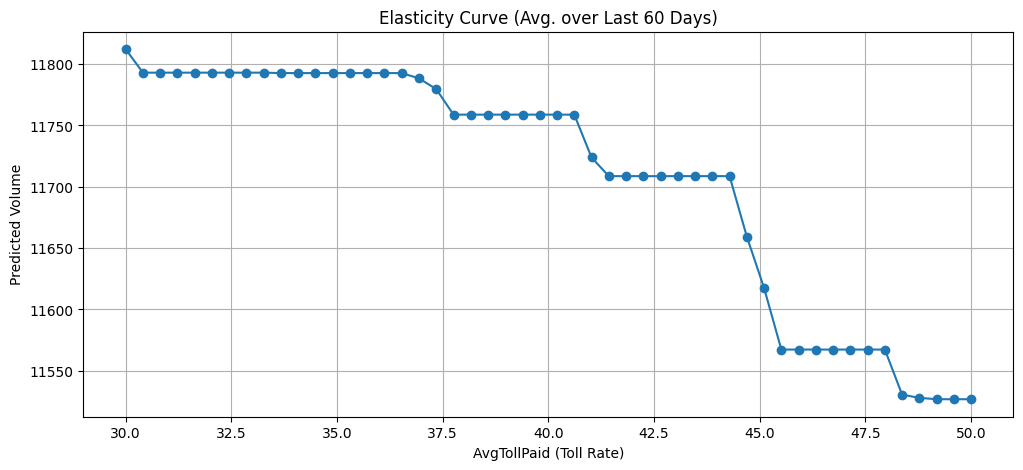

In [54]:
elasticity_results = plot_elasticity_curve(model, df_ml, feature_cols, toll_range=(30, 50), horizon=60)

In [55]:
elasticity_results.head()

,AvgTollPaid,Predicted_Volume
0,30.000000,11812.156250
1,30.408163,11793.050781
2,30.816327,11793.050781
3,31.224490,11793.050781
4,31.632653,11793.050781
